# Figure 6b

This notebook loads the data and produces figure 6b. The intermediate file "figure6b_nbdadvantage_coefficients_bystate.csv" is calculated in the Analysis folder. The file "figure6b_combined.csv" is saved and reloaded here to be used for the figure. You can reproduce the figure by downloading the file from our data repository. 

In [1]:
plotsavedate = '20251031'

In [2]:
data_path = '' # path to data - not needed for you to rerun figure
figure_data_folder  = '' # save the data from the data repository here in a subfolder called "FigureData"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import copy
DC_STATEHOOD=True
import us
import statsmodels.api as sm

## Load and Compile Data

In [4]:
# Load data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Share of EVs by state
tmp1 = df_bg_level.groupby('STATEFP')[['EVs_byState']].mean().reset_index() 
tmp2 = df_bg_level.groupby('STATEFP')[['cars_byState']].mean().reset_index()
tmp1 = tmp1.merge(tmp2, on='STATEFP')
tmp1['share_EVs_byState'] = 100*(tmp1['EVs_byState'] / tmp1['cars_byState'])

# Add state abbreviations
for i in tmp1.index:
    if tmp1.loc[i, 'STATEFP'] == '11':
        tmp1.loc[i, 'STUSPS'] = 'DC'
    else:
        tmp1.loc[i, 'STUSPS'] = us.states.lookup(tmp1.loc[i, 'STATEFP']).abbr
        
# Load coefficients
coeffs_by_state = pd.read_csv(figure_data_folder + 'FigureData/figure6b_nbdadvantage_coefficients_bystate.csv', index_col=0)
coeffs_by_state = coeffs_by_state.T.reset_index().rename(columns={'index':'STUSPS', 
                                                                  'median_household_income_imputed_10k':'localBG_10km',
                                                                  'av_income_10km_withoutBG_imputed_10k':'neighBG_10km'})

# Combine
df_plot = coeffs_by_state.merge(tmp1[['STUSPS', 'share_EVs_byState']], on='STUSPS', how='outer')

## Save and reload

In [5]:
# Save
df_plot.to_csv(figure_data_folder + 'FigureData/figure6b_combined.csv')

### Run from here if reloading data

In [6]:
# Reload
df_plot = pd.read_csv(figure_data_folder + 'FigureData/figure6b_combined.csv', index_col=0)

# Plotting

In [7]:
def stars(pval):
    if pval < 0.05:
        if pval < 0.01:
            if pval < 0.001:
                return "***"
            else:
                return "**"
        else:
            return '*'
    else:
        return ''

# Figure 6 b

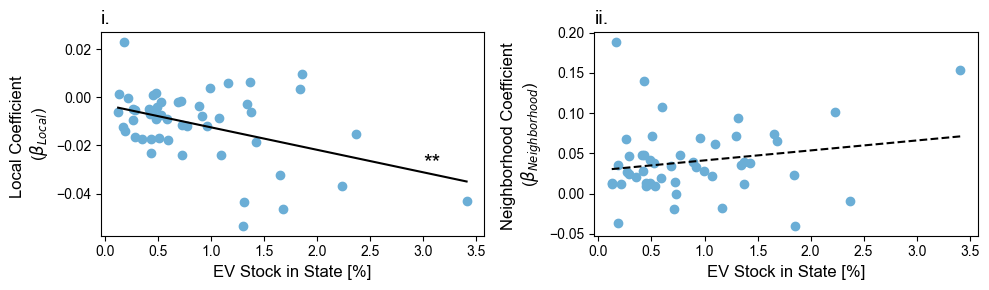

In [8]:
linecolor='k'
dotcolor='#6baed6'

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(df_plot['share_EVs_byState'], df_plot['localBG_10km'], color=dotcolor)
axes[0].set_xlabel('EV Stock in State [%]', fontsize=12)
axes[0].set_ylabel('Local Coefficient \n($\\beta_{Local}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['share_EVs_byState'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['localBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[0].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[0].annotate(stars(model.pvalues[1]), (3, -0.03), fontsize=16, color=linecolor)
# print('Model 0:', model.params, model.pvalues)

axes[1].scatter(df_plot['share_EVs_byState'], df_plot['neighBG_10km'], color=dotcolor)
axes[1].set_xlabel('EV Stock in State [%]', fontsize=12)
axes[1].set_ylabel('Neighborhood Coefficient \n($\\beta_{Neighborhood}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['share_EVs_byState'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['neighBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[1].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[1].annotate(stars(model.pvalues[1]), (0.19, -0.009), fontsize=16, color=linecolor)
# print('Model 1:', model.params, model.pvalues)

axes[0].set_title('i.', loc='left', fontsize=14)
axes[1].set_title('ii.', loc='left', fontsize=14)

plt.tight_layout()
plt.savefig('Figures/figure6b_stock_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figure6b_stock_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()